In [4]:
!pip install streamlit

In [5]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.spatial import distance

In [6]:
df = pd.read_csv('/content/dataset.csv')
df.sample(5)

<ipython-input-6-5e8cea8f0a47>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/dataset.csv')


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
12950,12950,1pgF9ARRXIBJlhzQ0XqYdK,Karen Mok,含情莫莫.莫文蔚全精選集,盛夏的果實,41.0,250795.0,False,0.631,0.304,...,-11.571,0.0,0.0300,0.847000,0.000005,0.279,0.328,165.996,4.0,cantopop
43665,43665,6sF9RjK9LDuChxWIlgrMRy,Nando Fortunato,This Fire in Me I the Album,Important Story,39.0,349655.0,False,0.771,0.626,...,-6.776,0.0,0.0335,0.209000,0.253000,0.109,0.362,116.001,4.0,groove
45961,45961,7sDYNHCFSDx0eKPhby4zgm,Project AER;WYS,Growth Patterns,Open Eyes,40.0,155714.0,False,0.694,0.225,...,-19.029,0.0,0.0320,0.479000,0.754000,0.109,0.204,130.094,4.0,guitar
55385,55385,2o00edfZxmZ1v8NzwKB8rA,Pritam;Shilpa Rao;Darshan Raval;Shashwat Singh...,Tadap,Tere Siva Jag Mein,53.0,206089.0,False,0.722,0.821,...,-5.325,1.0,0.0567,0.052800,0.000038,0.196,0.752,121.993,4.0,indian
50767,50767,64tUv2aAhLl2rZCtho95Cf,Almafuerte,Trillando la Fina,Mamuil Mapu,21.0,170173.0,False,0.559,0.957,...,-3.607,1.0,0.0502,0.000819,0.000004,0.226,0.379,109.995,4.0,heavy-metal


In [7]:
ncols, nrows = df.shape
print(f'Dataset has {ncols} rows and {nrows} columns')

Dataset has 72189 rows and 21 columns


In [8]:
duplicated_rows = df.duplicated().sum()

if duplicated_rows == 0:
    print('There are 0 rows that are duplicated, which means each row in the DataFrame is unique.')
    print('So that we do not need to continue processing duplicate lines')
else:
    print(f'There are {duplicated_rows} rows that are duplicated so we need to drop those {duplicated_rows} rows')
    df = df.drop_duplicates()
    print(f'After drop duplicated rows, there are {df.shape[0]} rows left')

There are 0 rows that are duplicated, which means each row in the DataFrame is unique.
So that we do not need to continue processing duplicate lines


In [9]:
df.dtypes.to_frame('Data Type')

,Data Type
Unnamed: 0,int64
track_id,object
artists,object
album_name,object
track_name,object
popularity,float64
duration_ms,float64
explicit,object
danceability,float64
energy,float64


In [10]:
def open_object_dtype(s):
    dtypes = set()
    dtypes.update(s.apply(type))
    return dtypes

obj_cols = df.select_dtypes(include='object').columns
df[obj_cols].apply(open_object_dtype, axis=0).to_frame('Data Type')

,Data Type
track_id,{<class 'str'>}
artists,"{<class 'float'>, <class 'str'>}"
album_name,"{<class 'float'>, <class 'str'>}"
track_name,"{<class 'float'>, <class 'str'>}"
explicit,"{<class 'float'>, <class 'bool'>}"
track_genre,"{<class 'float'>, <class 'str'>}"


In [11]:
# Missing values in each row
missing_values_per_row = df.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (df.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

72187 row(s) have 0 missing values
1 row(s) have 3 missing values
1 row(s) have 16 missing values
Total number of rows with missing values: 2


# Data Distribution  

In [12]:
numerical_cols = df[df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]]
numerical_cols.shape

(72189, 15)

In [14]:
numerical_cols.sample(5)

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
72188,72188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59701,59701,1.0,525000.0,0.132,0.187,3.0,-19.351,1.0,0.0526,0.17000,0.776000,0.2100,0.0339,172.802,3.0
62425,62425,63.0,242912.0,0.650,0.880,4.0,-5.326,1.0,0.0283,0.36000,0.003690,0.2300,0.9210,124.985,4.0
48442,48442,34.0,178413.0,0.543,0.836,10.0,-3.962,1.0,0.0421,0.00006,0.000001,0.0902,0.7300,125.004,4.0
33822,33822,43.0,157080.0,0.519,0.924,7.0,-2.392,1.0,0.0542,0.02880,0.000000,0.2230,0.8830,119.969,4.0


In [15]:
dist_numerical_cols = numerical_cols.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = numerical_cols.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (numerical_cols.isnull().mean() * 100).round(2)
# The number of -1 values in the 'key' column
dist_numerical_cols.loc['key', 'Missing Values'] = (df['key'] == -1).sum()
dist_numerical_cols

,min,max,Missing Values,Missing Percentage
Unnamed: 0,0.00000,72188.000,0,0.0
popularity,0.00000,100.000,1,0.0
duration_ms,0.00000,4789026.000,1,0.0
danceability,0.00000,0.984,1,0.0
energy,0.00002,1.000,1,0.0
key,0.00000,11.000,0,0.0
loudness,-42.04400,4.532,1,0.0
mode,0.00000,1.000,1,0.0
speechiness,0.00000,0.965,1,0.0
acousticness,0.00000,0.996,1,0.0


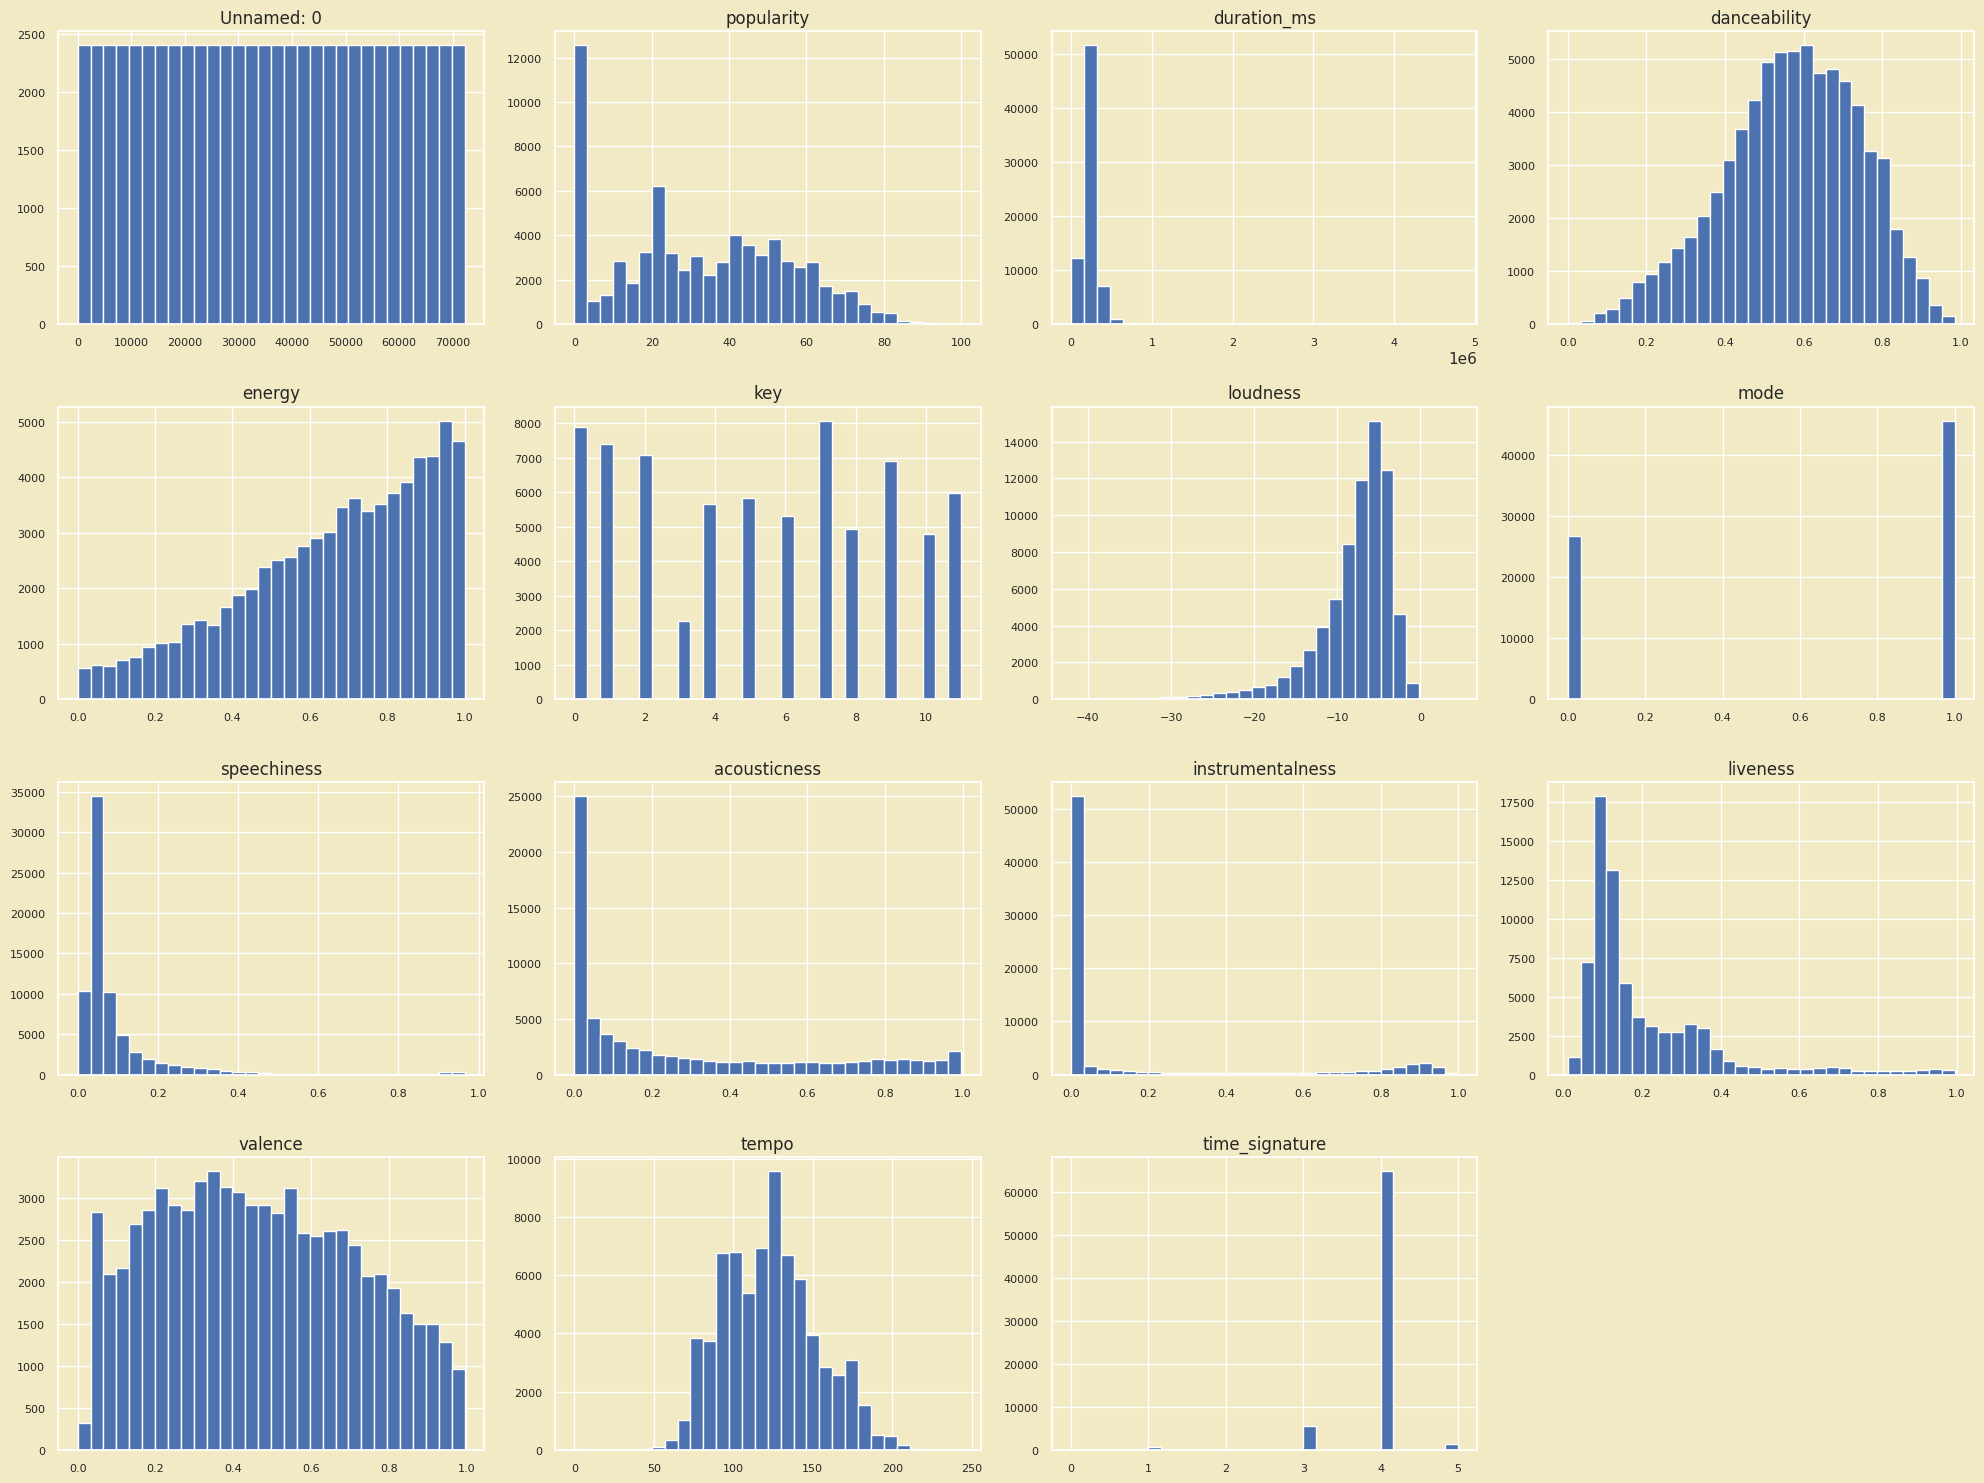

In [16]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
numerical_cols.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [17]:
categorical_cols = df[df.columns[(df.dtypes == 'object') | (df.dtypes == 'bool')]]
categorical_cols.shape

(72189, 6)

In [18]:
categorical_cols.sample(5)

,track_id,artists,album_name,track_name,explicit,track_genre
52566,0Vr5DJC7aJvk0uYROgGPU0,Railbenders,Showdown,Leavin' Song,False,honky-tonk
2974,0fRQGN6XS01UzZbKNj6sQp,Bandalos Chinos,Cállame,Cállame,False,alt-rock
45921,5iEv15cIwHtxh96FpDKatM,Little Symphony,Rialto Beach,Elirid,False,guitar
852,5MZYOtR8fcaZoWzweBNdMm,Brandon Chase;Taylor Manns,Dilemma,Dilemma,False,acoustic
14475,6ho8wfb3tVfn47wDEZTtgc,Super Simple Songs,As Quiet As A Mouse & More Kids Songs,Hush Little Baby,False,children


In [22]:
dist_categorical_cols = pd.DataFrame(
    data = {
        'Missing Values': categorical_cols.isnull().sum(),
        'Missing Percentage': (categorical_cols.isnull().mean() * 100)
    }
)
dist_categorical_cols

,Missing Values,Missing Percentage
track_id,0,0.000000
artists,1,0.001385
album_name,1,0.001385
track_name,1,0.001385
explicit,1,0.001385
track_genre,1,0.001385


In [23]:
categorical_cols[categorical_cols.isnull().any(axis=1)]

,track_id,artists,album_name,track_name,explicit,track_genre
65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,False,k-pop
72188,2mMNBgFRyEiRoGvrdoONeq,Ice Nine Kills,The Silver Scream,A Grave,NaN,NaN


In [24]:
index_to_drop = df[categorical_cols.isnull().any(axis=1)].index
df.drop(index_to_drop, inplace=True)

print(f'Rows with missing values dropped. Updated DataFrame shape: {df.shape}')

Rows with missing values dropped. Updated DataFrame shape: (72187, 21)


In [25]:
df.describe(include=['object', 'bool'])

,track_id,artists,album_name,track_name,explicit,track_genre
count,72187,72187,72187,72187,72187,72187
unique,60219,21143,31360,49831,2,73
top,1Gqpa08T7eBAvPQj9O9L2Q,George Jones,Metal,Last Last,False,acoustic
freq,6,271,132,75,64822,1000


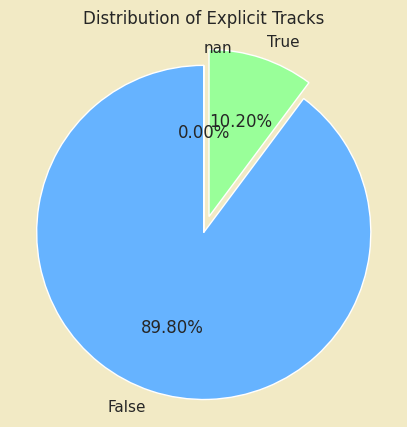

In [27]:
unique_values, value_counts = np.unique(categorical_cols['explicit'], return_counts=True)

fig, ax = plt.subplots(figsize=(5, 5))

# Explode the slice with explicit tracks for emphasis
explode = [0, 0.1, 0]  # Only "yes" (true) will be slightly exploded
colors = ['#66b3ff','#99ff99']

ax.pie(value_counts, labels=unique_values, autopct='%1.2f%%', startangle=90, colors=colors, explode=explode)
ax.axis('equal')
ax.set_title('Distribution of Explicit Tracks')
plt.show()

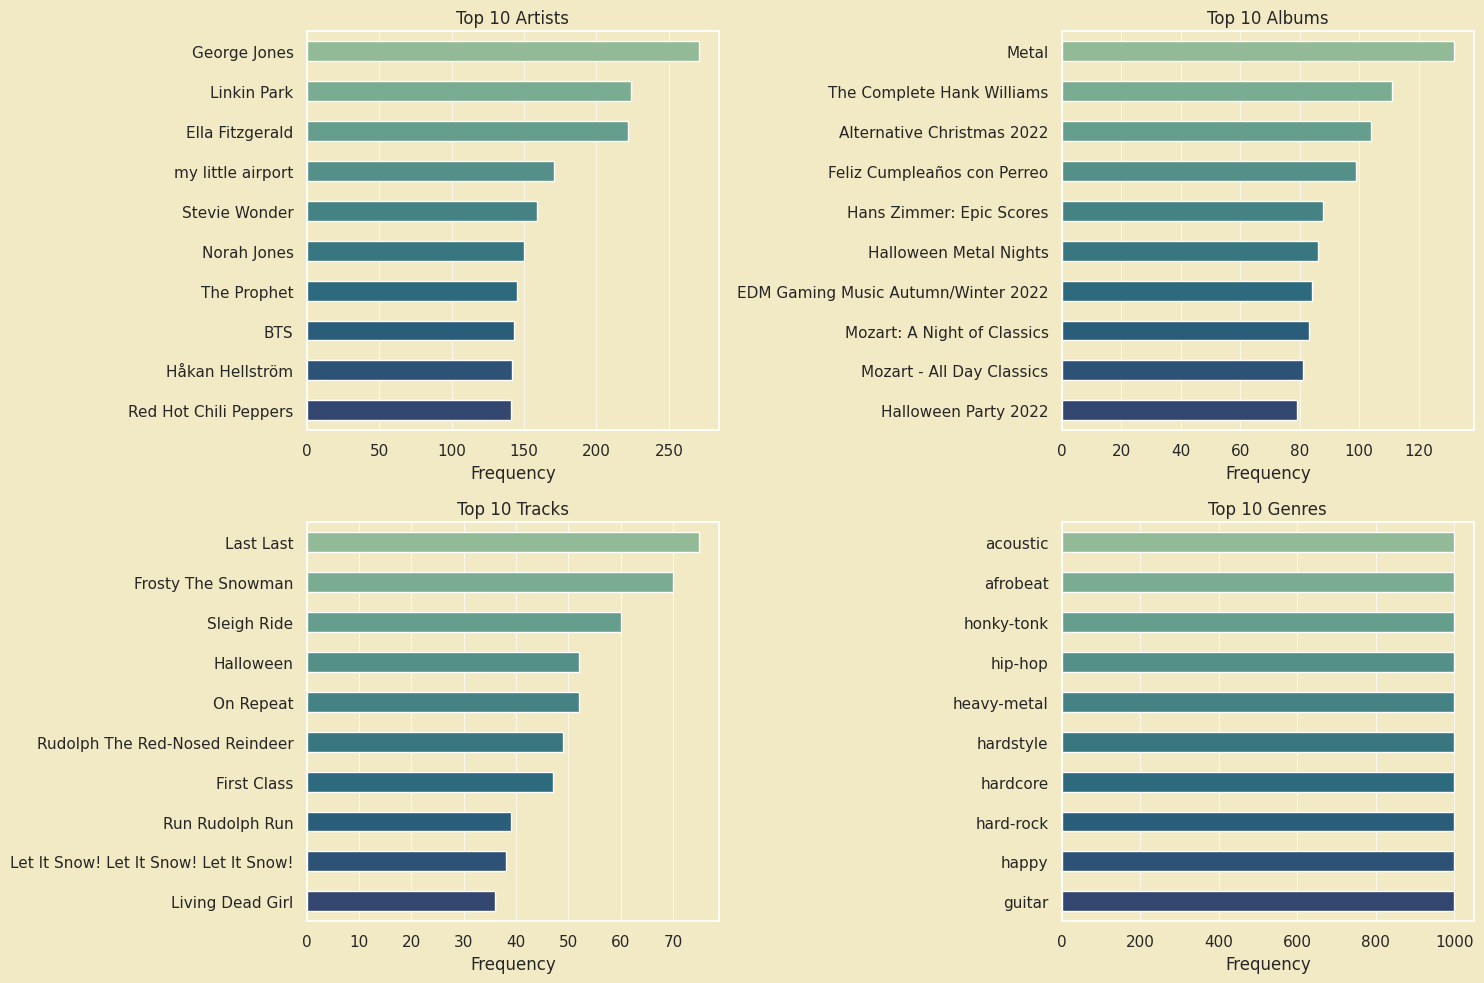

In [28]:
top_n = 10
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
# Get the top N most frequent artists, albums, tracks, and genres
top_artists = df['artists'].value_counts().head(top_n)
top_albums = df['album_name'].value_counts().head(top_n)
top_tracks = df['track_name'].value_counts().head(top_n)
top_genres = df['track_genre'].value_counts().head(top_n)

# Disable FutureWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Plotting
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    # Top N Artists
    sns.barplot(x=top_artists.values, y=top_artists.index, palette="crest", ax=axes[0, 0], orient='h',  zorder=3, width=0.5)
    axes[0, 0].set_title(f'Top {top_n} Artists')
    axes[0, 0].set_xlabel('Frequency')
    axes[0, 0].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Albums
    sns.barplot(x=top_albums.values, y=top_albums.index, palette="crest", ax=axes[0, 1], orient='h', zorder=3, width=0.5)
    axes[0, 1].set_title(f'Top {top_n} Albums')
    axes[0, 1].set_xlabel('Frequency')
    axes[0, 1].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Tracks
    sns.barplot(x=top_tracks.values, y=top_tracks.index, palette="crest", ax=axes[1, 0], orient='h', zorder=3, width=0.5)
    axes[1, 0].set_title(f'Top {top_n} Tracks')
    axes[1, 0].set_xlabel('Frequency')
    axes[1, 0].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Genres
    sns.barplot(x=top_genres.values, y=top_genres.index, palette="crest", ax=axes[1, 1], orient='h', zorder=3, width=0.5)
    axes[1, 1].set_title(f'Top {top_n} Genres')
    axes[1, 1].set_xlabel('Frequency')
    axes[1, 1].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    plt.tight_layout()
    plt.show()

# Abnormal values and outliers

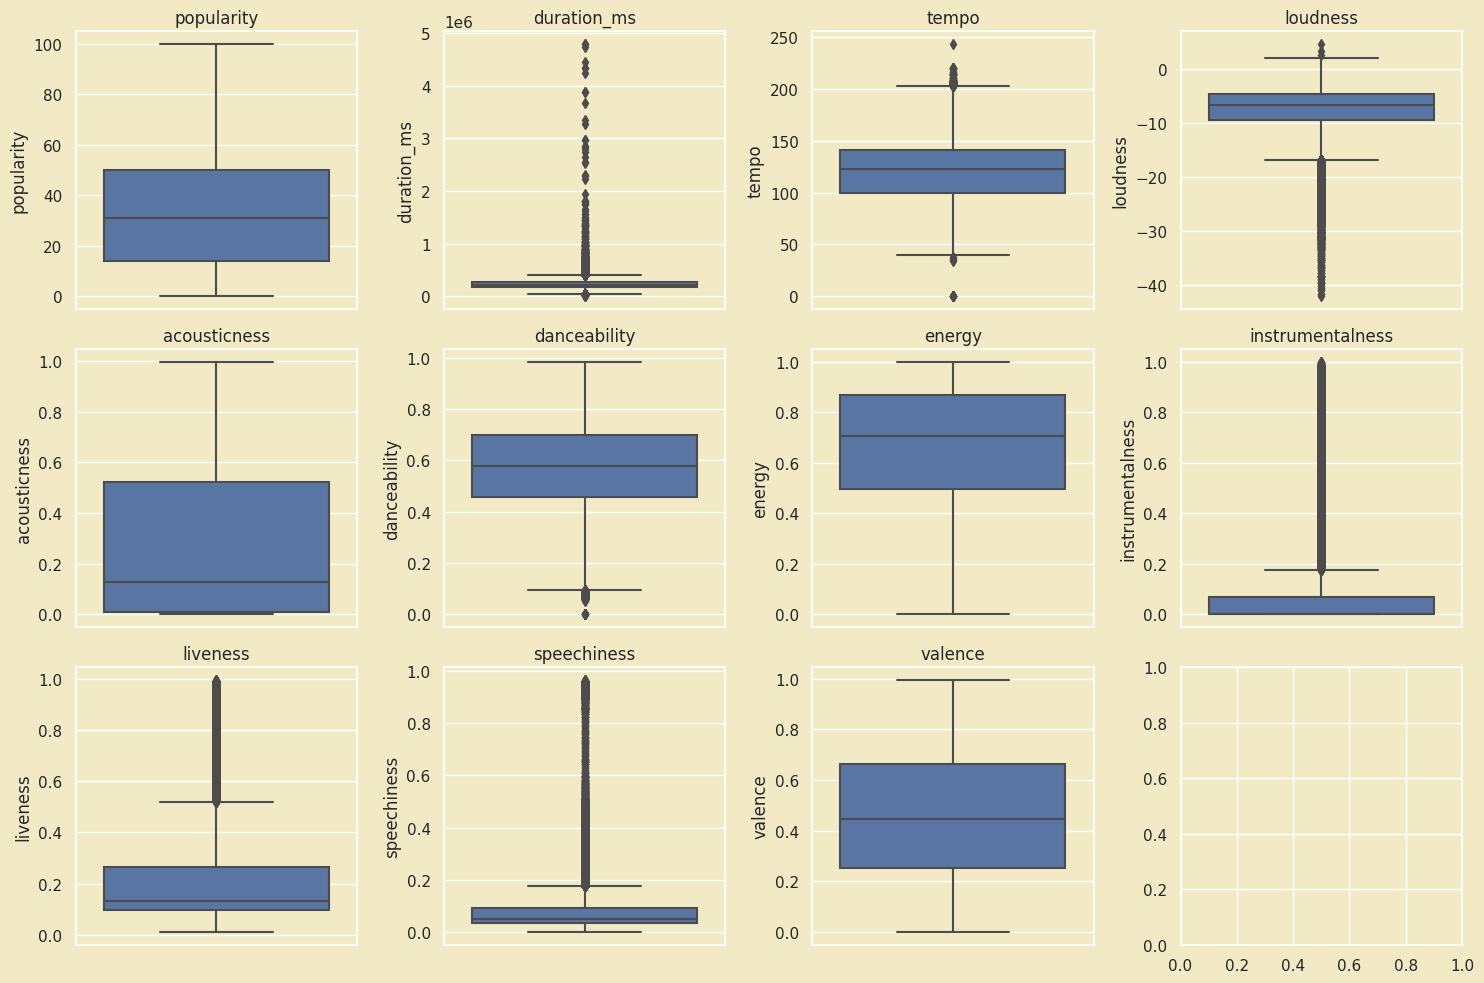

In [29]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
columns = ['popularity', 'duration_ms', 'tempo', 'loudness', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for i, col in enumerate(columns):
    sns.boxplot(y=col, data=numerical_cols, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(col)
plt.tight_layout()
plt.show()

# Correlation between variables

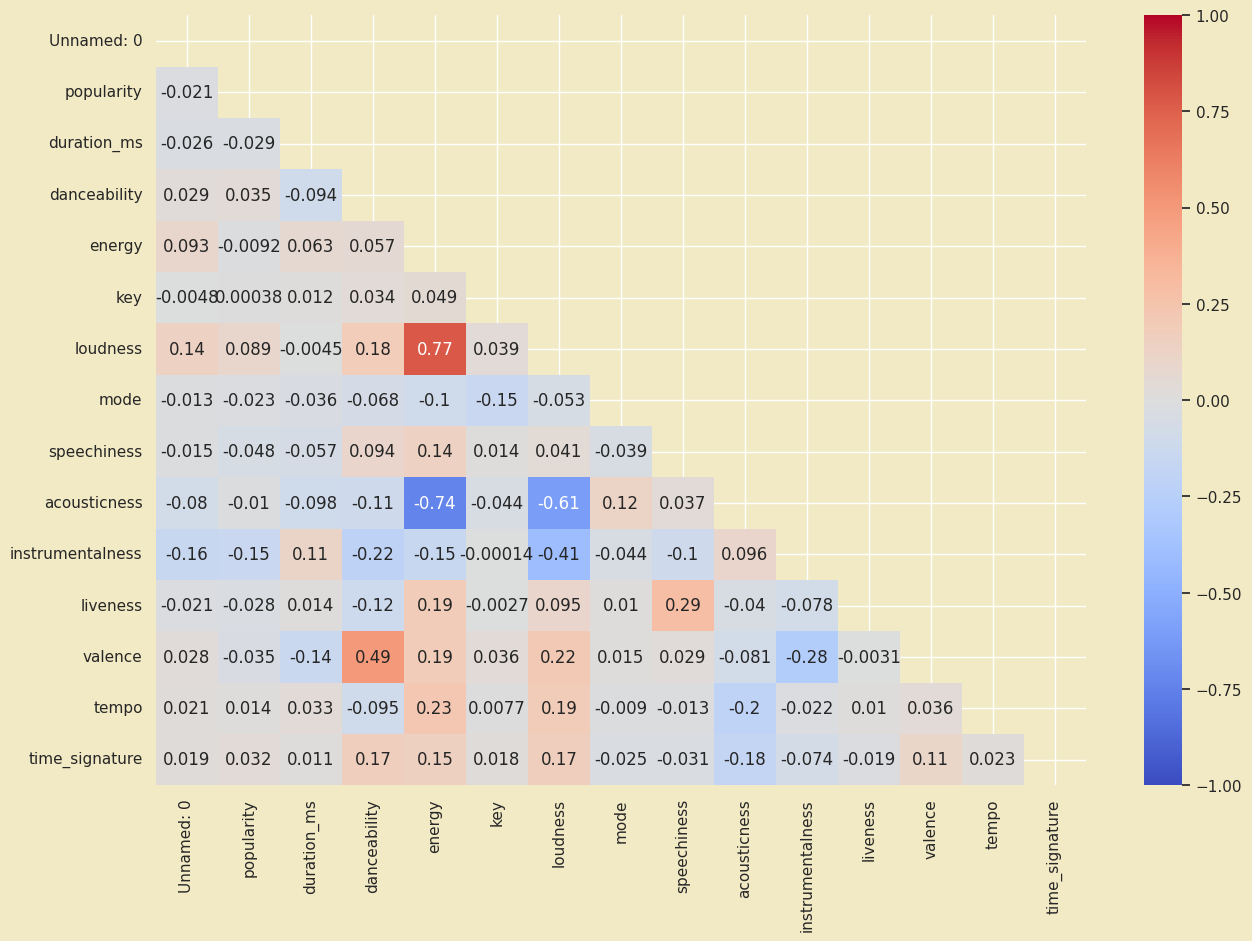

In [30]:
# heatmap for correlation
corr = numerical_cols.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set_style('white')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
plt.figure(figsize=(15, 10))
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1,cmap='coolwarm')
plt.show()

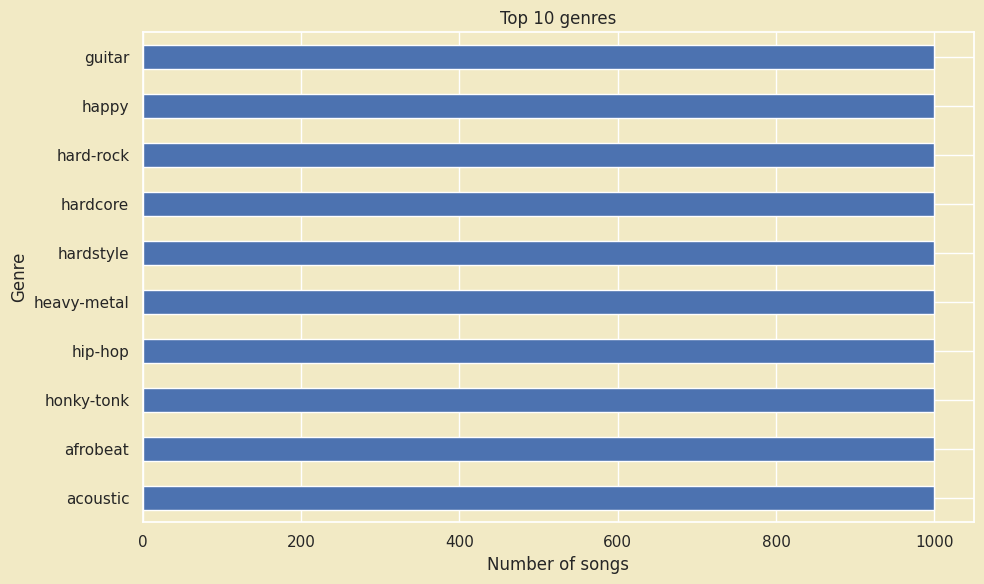

In [31]:
genre_counts = df['track_genre'].value_counts()
top_10_genres = genre_counts.head(10)

plt.figure(figsize=(10, 6))
top_10_genres.plot(kind='barh')
plt.title('Top 10 genres')
plt.xlabel('Number of songs')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

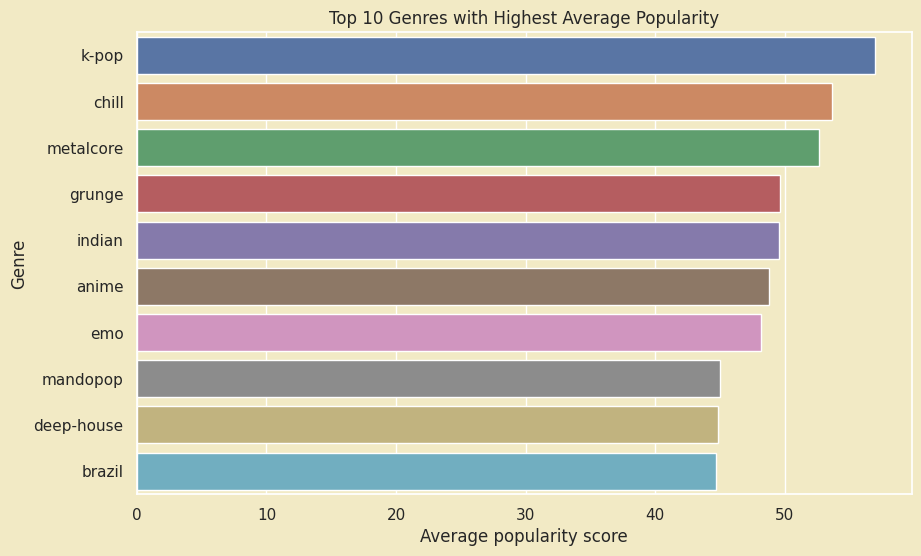

In [32]:
avg_popularity_by_genre = df.groupby('track_genre')['popularity'].mean().reset_index()
top10_popular_genres = avg_popularity_by_genre.nlargest(10, 'popularity')

plt.figure(figsize=(10, 6))
sns.barplot(x='popularity', y='track_genre', data=top10_popular_genres)
plt.title('Top 10 Genres with Highest Average Popularity')
plt.xlabel('Average popularity score')
plt.ylabel('Genre')
plt.show()

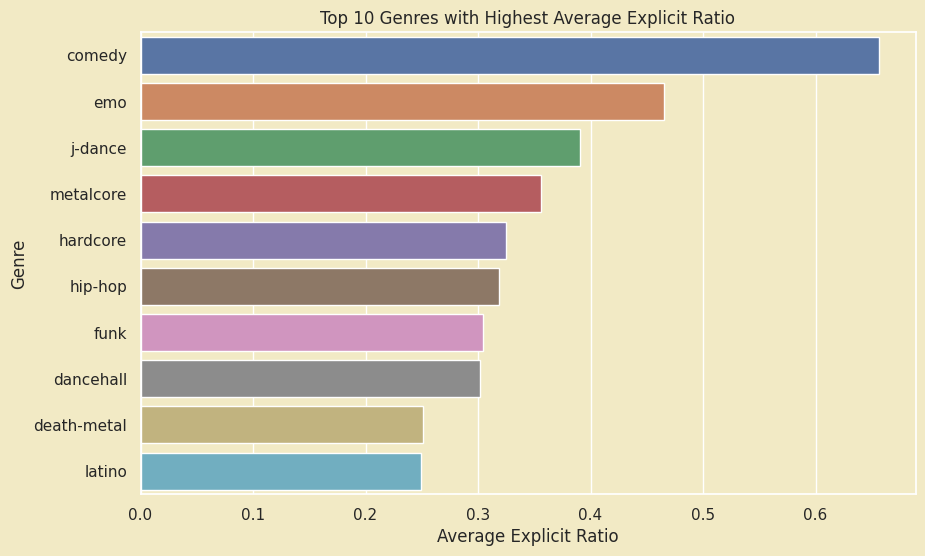

In [33]:
explicit_ratio_by_genre = df.groupby('track_genre')['explicit'].mean().reset_index()
top5_explicit_genres = explicit_ratio_by_genre.nlargest(10, 'explicit')

plt.figure(figsize=(10, 6))
sns.barplot(x='explicit', y='track_genre', data=top5_explicit_genres)
plt.title('Top 10 Genres with Highest Average Explicit Ratio')
plt.xlabel('Average Explicit Ratio')
plt.ylabel('Genre')
plt.show()

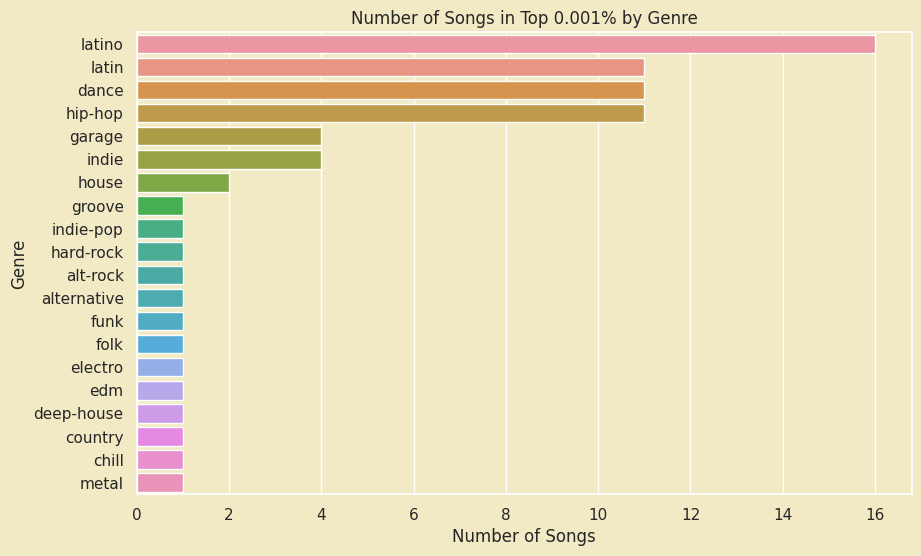

The genre with the most songs in the top 0.001% is latino with 16 songs.


In [34]:
df_sorted = df.sort_values(by='popularity', ascending=False)

top_10_percent = df_sorted.head(int(0.001 * len(df_sorted)))

top_genres_count = top_10_percent.groupby('track_genre').size().reset_index(name='count')
top_genres_count = top_genres_count.sort_values(by='count', ascending=False)

most_common_genre = top_genres_count.loc[top_genres_count['count'].idxmax()]

# Bước 5: Visualize Kết Quả
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='track_genre', data=top_genres_count)
plt.title('Number of Songs in Top 0.001% by Genre')
plt.xlabel('Number of Songs')
plt.ylabel('Genre')
plt.show()

print(f"The genre with the most songs in the top 0.001% is {most_common_genre['track_genre']} with {most_common_genre['count']} songs.")


# Based on the Correlation section in the Exploring and Preprocessing file, we find that the highest correlation is between loudness and energy.

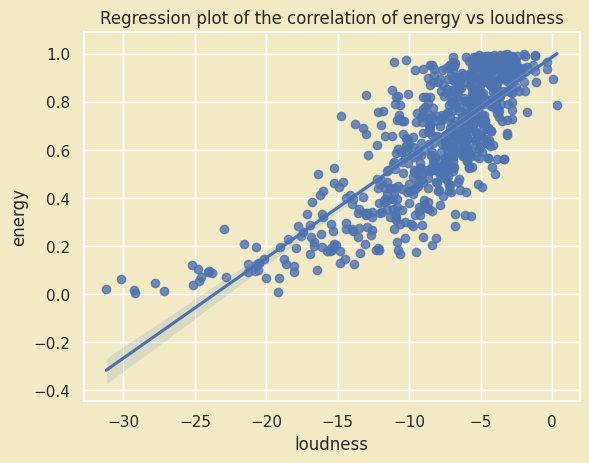

In [35]:
sample = df.sample(int(0.01 * len(df)))
sns.regplot(data=sample, y="energy", x="loudness", color="b")
plt.title("Regression plot of the correlation of energy vs loudness")
plt.show()

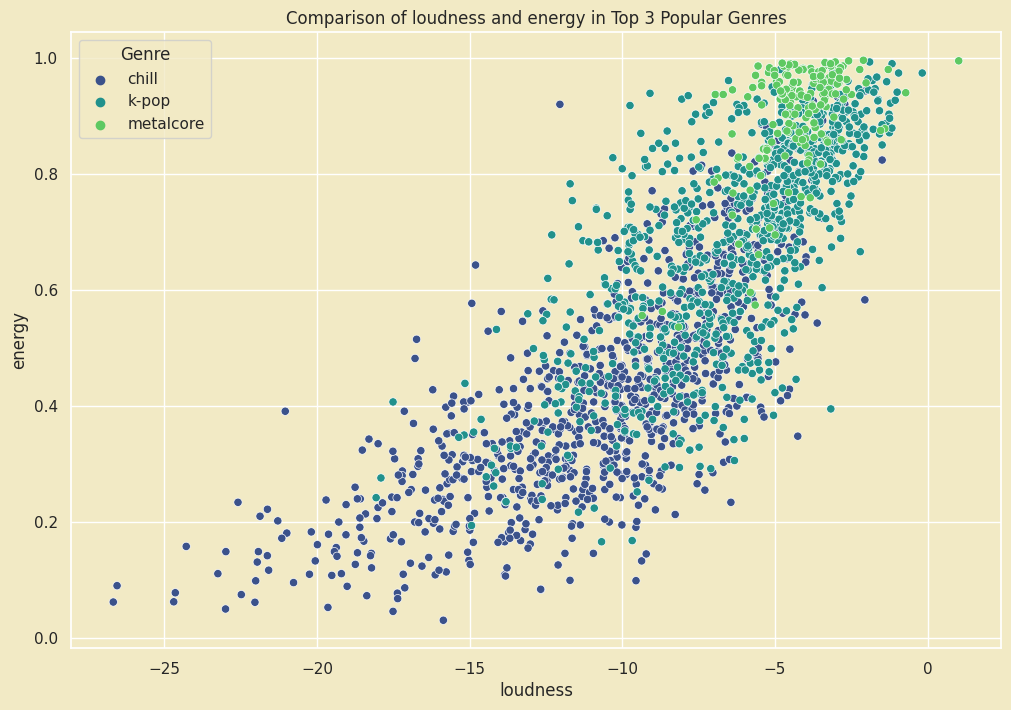

In [36]:
avg_popularity_by_genre = df.groupby('track_genre')['popularity'].mean().reset_index()

top3_popular_genres = avg_popularity_by_genre.nlargest(3, 'popularity')

top3_genre_data = df[df['track_genre'].isin(top3_popular_genres['track_genre'])]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='loudness', y='energy', hue='track_genre', data=top3_genre_data, palette='viridis')
plt.title('Comparison of loudness and energy in Top 3 Popular Genres')
plt.xlabel('loudness')
plt.ylabel('energy')
plt.legend(title='Genre')
plt.show()